In [1]:

import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_jsonl(file_path: str) -> list[list[dict]]:
    """
    Load and parse a file where each line is a JSON-encoded string representing
    a participant's response data across trials.

    Args:
        file_path: Path to the file containing the data.

    Returns:
        participants_data: Inner lists contain recorded entries for a participant and trial.
    """
    participants_data = []
    with open(file_path, "r") as file:
        for line in file:
            try:
                participant_data = json.loads(line.strip())
                participants_data.append(participant_data)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")
    return participants_data


def retrieve_conditions(participants_data: list[list[dict]]) -> list[str]:
    """
    Retrieve the condition of each participant from the data.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        conditions: Contains the condition of each participant.
    """
    conditions = []
    for participant_data in participants_data:
        condition = next(
            (
                ["Casual", "Competitive"][entry["condition"]]
                for entry in participant_data
                if entry.get("condition", None) is not None
            ),
            None,
        )
        assert condition is not None, "Condition not found for participant"
        conditions.append(condition)
    return conditions


def retrieve_copeland_ranks(participants_data: list[list[dict]]) -> list[list[int]]:
    """
    Tabulate the Copeland score for each item based on forced-choice trials.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        all_scores: Inner lists contain the Copeland score of items for a participant.
    """
    all_rankings = []
    for participant_data in participants_data:
        counts = {}
        for entry in participant_data:
            if entry.get("winner") is not None:
                winner = entry["winner"]
                loser = entry["loser"]
                if winner not in counts:
                    counts[winner] = [1, 0]
                else:
                    counts[winner] = [counts[winner][0] + 1, counts[winner][1]]
                if loser not in counts:
                    counts[loser] = [0, 1]
                else:
                    counts[loser] = [counts[loser][0], counts[loser][1] + 1]
        scores = [counts[i][0] - counts[i][1] for i in range(len(counts))]
        ranking = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        all_rankings.append([each+1 for each in ranking])
    return all_rankings


def retrieve_choice_ranking(participants_data: list[list[dict]]) -> list[list[str]]:
    """Retrieve a copeland ranking of rated characters based on forced-choice trials.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        choice_rankings: Inner lists contain the copeland ranking of items for a participant.
    """
    rankings = retrieve_copeland_ranks(participants_data)
    all_characters = []
    for participant_index, participant_data in enumerate(participants_data):
        characters = {}
        for entry in participant_data:
            if entry.get("winner") is None:
                continue
            left = entry["left_index"]
            right = entry["right_index"]
            if left not in characters:
                characters[left] = {"rank": rankings[participant_index][left], "index": left, "label": entry['left_image']}
            if right not in characters:
                characters[right] = {"rank": rankings[participant_index][right], "index": right, "label": entry['right_image']}
        all_characters.append(sorted(characters.values(), key=lambda x: x["rank"]))
    return all_characters


def retrieve_subj_demographics(participants_data: list[list[dict]]) -> list[tuple]:
    """
    Returns the self-reported demographics of each participant.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.
    """

    full_demographics = []
    for participant_data in participants_data:
        demographics = [
            (
                entry["response"]["race"],
                entry["response"]["gender"],
                int(entry["response"]["age"]),
                entry["response"]["college"],
            )
            for entry in participant_data
            if type(entry.get("response")) is dict
            and entry["response"].get("race") is not None
        ]
        full_demographics.append(demographics[0])
    return full_demographics


def retrieve_deception(participants_data: list[list[dict]]) -> list[str]:
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = [
            entry["response"]["deception"]
            for entry in participant_data
            if type(entry.get("response")) is dict
            and entry["response"].get("deception") is not None
        ]
        final_rankings.append(final_ranking[0])
    return final_rankings


def retrieve_confidence(participants_data: list[list[dict]]) -> list[int]:
    """
    Retrieve participant self rating of their competitive confidence.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        confidence: Inner lists self-rating for each participant
    """
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = [
            int(entry["response"])
            for entry in participant_data
            if entry.get("stimulus")
            == "<h2>Rating</h2><p>On a scale from 1–10, how typically successful are you in competitive environments?</p>"
        ]
        final_rankings.append(final_ranking)
    return final_rankings


def retrieve_full_ranking(participants_data: list[list[dict]]) -> list[list[str]]:
    """
    Retrieve the final ranking of items from the data.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        final_rankings: Inner lists contain the final ranking of items for a participant.
    """
    final_rankings = []
    for participant_data in participants_data:
        final_ranking = []
        for entry in participant_data:
            if entry.get("trial_type") == "sortable-rank":
                rank = 1
                for character in entry["team_left_items"]:
                    if character["label"] == "locked":
                        continue
                    final_ranking.append(
                        {
                            "label": character["label"],
                            "content": character["content"],
                            "team": "Your Team",
                            "rank": rank,
                            "index": character["index"],
                        }
                    )
                    rank += 1

                for character in entry["team_right_items"]:
                    final_ranking.append(
                        {
                            "label": character["label"],
                            "content": character["content"],
                            "team": "Other Team",
                            "rank": rank,
                            "index": character["index"],
                        }
                    )
                    rank += 1

                final_rankings.append(final_ranking)
                break
    return final_rankings



def retrieve_task_ordering(participants_data: list[list[dict]]) -> list[str]:
    """
    Retrieve ordering of choice and ranking tasks for each participant.
    0 = choice task first, 1 = ranking task first.
    """

    # first find trial index of first choice task
    orderings = []
    for participant_data in participants_data:
        for sortable_rank_index, entry in enumerate(participant_data):
            if entry.get("trial_type") == "sortable-rank":
                break
        for choice_index, entry in enumerate(participant_data):
            if entry.get("winner") is not None:
                break
        orderings.append(0 if choice_index < sortable_rank_index else 1)
    return orderings



def generate_subject_ids(participants_data: list[list[dict]]) -> list[int]:
    """
    Selects unique subject id from item-presentation trials across all participants.

    Args:
        participants_data: List of lists of dictionaries, where each inner list contains recorded entries for a participant and trial.

    Returns:
        Contains subject id for a participant and trial combination.
    """
    subject_ids = []
    for subject_id, participant_data in enumerate(participants_data):
        subject_ids.extend(
            subject_id
            for entry in participant_data
            if entry.get("trial_type") == "item-presentation"
        )
    return subject_ids


def extract_race_gender_age(url):
    # Extract the final part of the URL (filename without extension)
    filename = url.split("/")[-1].split(".")[0].lower()
    return filename.split("_")[2:]


def compare_race(raceA: str, raceB: str) -> bool:
    """
    "Asian/Pacific Islander" should match with "Asian-Pacific Islander"
    "Black" should match with "African-American"
    "White" should match with "White"
    "Latino" should match with "Latinx"
    Otherwise no match
    """
    codes = {
        "South Asian": 0,
        "south-asian": 0,
        "East/Southeast Asian": 1,
        "east-asian": 1,
        "Black": 2,
        "black": 2,
        "White": 3,
        "white": 3,
        "Hispanic/Latine/Latinx": 4,
        "latino": 4,
        "Indigenous": 5,
        "Multiracial": 6,
        "Other": 7,
    }
    if codes.get(raceA, np.nan) == codes.get(raceB, np.nan):
        return True
    return False

def convert_race(race: str) -> str:
    races = ["South Asian", "East/Southeast Asian", "Black", "White", "Latino", "Indigenous", "Multiracial", "Other"]
    codes = {
        "South Asian": 0,
        "south-asian": 0,
        "East/Southeast Asian": 1,
        "east-asian": 1,
        "Black": 2,
        "black": 2,
        "White": 3,
        "white": 3,
        "Hispanic/Latine/Latinx": 4,
        "latino": 4,
        "Indigenous": 5,
        "Multiracial": 6,
        "Other": 7,
    }
    return races[codes.get(race)]

def convert_age(age_int: int) -> str|float:
    """
    Convert age_int into age_str based on the following rules:
        - If age_int is <= 24, return "18-24"
        - If age_int is between 25 and 31 (inclusive), return "25-31"
        - If age_int is between 32 and 38 (inclusive), return "32-38"
        - If age_int is above 39 and 45 (inclusive), return "39-45"
        - If age_int is above 45, return "45+"
    """
    if age_int <= 24:
        return "18-24"
    elif age_int >= 25 and age_int <= 31:
        return "25-31"
    elif age_int >= 32 and age_int <= 38:
        return "32-38"
    elif age_int >= 39 and age_int <= 45:
        return "39-45"
    elif age_int > 45:
        return "45+"
    return np.nan

def convert_gender(gender: str) -> str:
    genders = ["Man", "Woman", "Non-binary", "Other"]
    codes = {
        "Man": 0,
        "male": 0,
        "man": 0,
        "Woman": 1,
        "woman": 1,
        "female": 1,
        "Non-binary": 2,
        "Other": 3,
    }
    return genders[codes.get(gender)]


jatos_data_path = "experiments/sortablerank/Team_Building_14_11_2024.jsonl"

data = load_jsonl(jatos_data_path)
full_rankings = retrieve_full_ranking(data)
task_orderings = retrieve_task_ordering(data)
choice_rankings = retrieve_choice_ranking(data)
conditions = retrieve_conditions(data)
subject_demographics = retrieve_subj_demographics(data)
subject_selfratings = retrieve_confidence(data)
subject_deceptions = retrieve_deception(data)

# analyses used: subject age, gender, race,
# dcharacter race, age, gender
# generated "shared_features" column
# output position. "chosen" extracted from output positions

merged = {
    "subject": [],  # ✅
    "task_type": [],
    "ordering": [], 
    "output": [],  # ✅
    "chosen": [],  # ✅
    "condition": [],  # ✅
    "subject_race": [],  # ✅
    "subject_age": [],  # ✅
    "subject_gender": [],  # ✅
    "character_race": [],  # ✅
    "character_age": [],  # ✅
    "character_gender": [],  # ✅
    "subj_college": [],  # ✅
    "self_ability": [],  # ✅
    "awareness": [],  # ✅
    "shared_features": [],  # ✅
}
for i in range(len(data)):
    subject_id = i + 1
    condition = conditions[i]

    # TODO: ill need two of these: one for forced choice and one for actual ranking
    subject_full_rankings = full_rankings[i]
    subject_choice_rankings = choice_rankings[i]
    subject_rankings = subject_full_rankings + subject_choice_rankings
    task_type = ["full_ranking"] * len(subject_full_rankings) + ["choice_ranking"] * len(subject_choice_rankings)
    ordering = task_orderings[i]
    subject_selfrating = subject_selfratings[i][0]
    subject_deception = subject_deceptions[i]
    subject_race, subject_gender, subject_age, subject_college = subject_demographics[i]

    chosen_threshold = int((len(subject_choice_rankings)-1)/2)
    for character_index, character in enumerate(subject_rankings):
        character_demographics = extract_race_gender_age(character["label"])
        if not character_demographics:
            continue
        character_race, character_gender, character_age = character_demographics
        output = character["rank"]
        chosen = output <= chosen_threshold
        
        shared_features = 0
        shared_features += compare_race(subject_race, character_race)
        shared_features += convert_age(subject_age) == convert_age(int(character_age))
        shared_features += convert_gender(subject_gender) == convert_gender(character_gender)

        merged["subject"].append(subject_id)
        merged["task_type"].append(task_type[character_index])
        merged["ordering"].append(ordering) #TODO: maybe redefine to be relative to task type
        merged["output"].append(output)
        merged["chosen"].append(chosen)
        merged["condition"].append(condition)
        merged["subject_race"].append(convert_race(subject_race))
        merged["subject_age"].append(convert_age(subject_age))
        merged["subject_gender"].append(convert_gender(subject_gender))
        merged["character_race"].append(convert_race(character_race))
        merged["character_gender"].append(convert_gender(character_gender))
        merged["character_age"].append(convert_age(int(character_age)))
        merged["subj_college"].append(subject_college)
        merged["self_ability"].append(subject_selfrating)
        merged["awareness"].append(subject_deception)
        merged["shared_features"].append(shared_features)

full_data = pd.DataFrame(merged)
full_data.head()

,subject,task_type,ordering,output,chosen,condition,subject_race,subject_age,subject_gender,character_race,character_age,character_gender,subj_college,self_ability,awareness,shared_features
0,1,full_ranking,1,1,True,Casual,South Asian,18-24,Man,South Asian,32-38,Man,yes,5,yes,2
1,1,full_ranking,1,2,True,Casual,South Asian,18-24,Man,East/Southeast Asian,25-31,Man,yes,5,yes,1
2,1,full_ranking,1,3,True,Casual,South Asian,18-24,Man,East/Southeast Asian,45+,Man,yes,5,yes,1
3,1,full_ranking,1,4,True,Casual,South Asian,18-24,Man,East/Southeast Asian,25-31,Woman,yes,5,yes,0
4,1,full_ranking,1,5,False,Casual,South Asian,18-24,Man,White,32-38,Woman,yes,5,yes,0


In [2]:
# data=full_data.query("task_type == 'choice_ranking'").copy()
# data=full_data.query("ordering == 1").copy().query("task_type == 'full_ranking'").copy()
data = full_data.copy()

In [3]:
data.value_counts(['subject_age'])/16

subject_age
32-38          19.125
39-45           3.375
18-24           1.125
25-31           1.125
Name: count, dtype: float64

In [4]:
data.value_counts(['subject_gender'])/16

subject_gender
Man               20.25
Woman              4.50
Name: count, dtype: float64

In [5]:
data.value_counts(['subject_race'])/16

subject_race        
White                   22.500
East/Southeast Asian     1.125
South Asian              1.125
Name: count, dtype: float64

In [6]:
pd.pivot_table(data, index='shared_features', values='chosen', aggfunc='mean')

,chosen
shared_features,
0,0.448276
1,0.429293
2,0.475000
3,0.500000


In [7]:
pd.pivot_table(data, index='shared_features', columns='condition', values='chosen', aggfunc='mean')

condition,Casual,Competitive
shared_features,,
0,0.500000,0.396552
1,0.372093,0.473214
2,0.500000,0.428571
3,0.500000,NaN


In [8]:
pd.pivot_table(data, index='output', values='shared_features', aggfunc='mean')

,shared_features
output,
1,1.045455
2,0.840909
3,0.954545
4,0.886364
5,0.795455
6,0.863636
7,0.954545
8,1.000000
9,0.931818


In [9]:
pd.pivot_table(data, index='subject_race', columns='character_race', values='chosen', aggfunc='mean')

character_race,Black,East/Southeast Asian,Latino,South Asian,White
subject_race,,,,,
East/Southeast Asian,0.50000,0.000000,0.750,0.333333,0.500000
South Asian,NaN,0.833333,0.125,1.000000,0.000000
White,0.33871,0.443182,0.400,0.514706,0.532258


In [10]:
pd.pivot_table(data, index='subject_gender', columns='character_gender', values='chosen', aggfunc='mean')

character_gender,Man,Woman
subject_gender,,
Man,0.440476,0.448718
Woman,0.392857,0.477273


In [11]:
pd.pivot_table(data, index='subject_age', columns='character_age', values='chosen', aggfunc='mean')

character_age,18-24,25-31,32-38,39-45,45+
subject_age,,,,,
18-24,0.000000,0.666667,0.500000,0.250,0.50
25-31,NaN,0.750000,0.000000,0.375,1.00
32-38,0.346154,0.473684,0.381579,0.625,0.45
39-45,0.500000,0.550000,0.333333,0.500,0.00


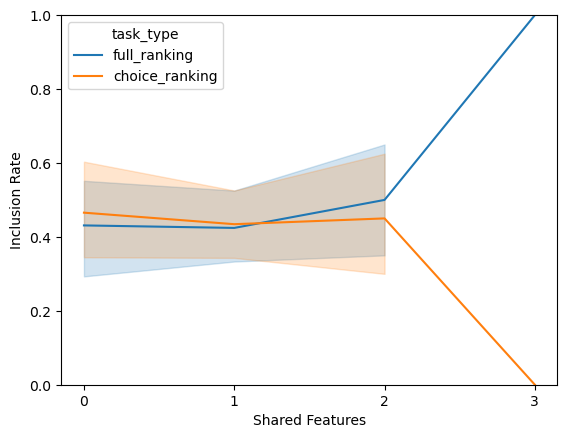

In [12]:
g = sns.lineplot(
    data=data, 
    x='shared_features', y='chosen', hue='task_type')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3])
g.set_ylim(0, 1)
g.set_ylabel('Inclusion Rate');

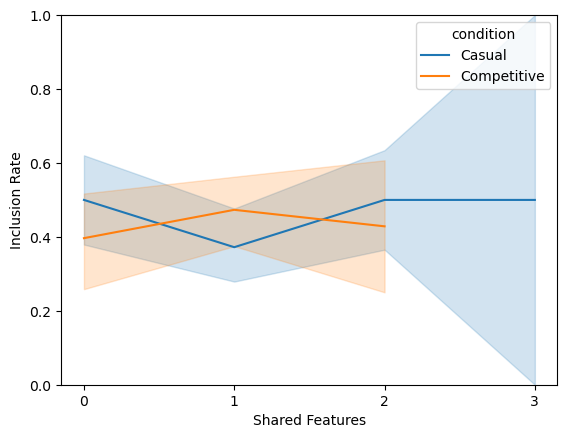

In [13]:
g = sns.lineplot(
    data=data, 
    x='shared_features', y='chosen', hue='condition')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3])
g.set_ylim(0, 1)
g.set_ylabel('Inclusion Rate');

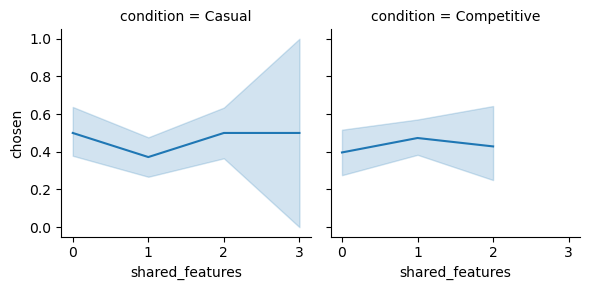

In [14]:

g = sns.FacetGrid(data, col='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

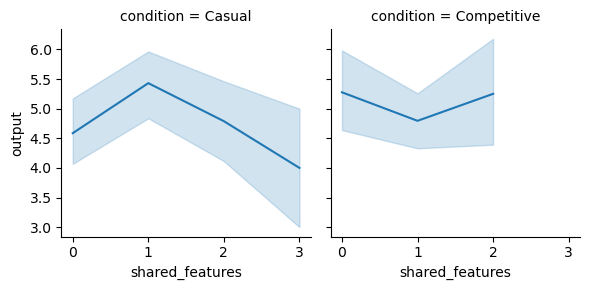

In [15]:
g = sns.FacetGrid(data, col='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'output')

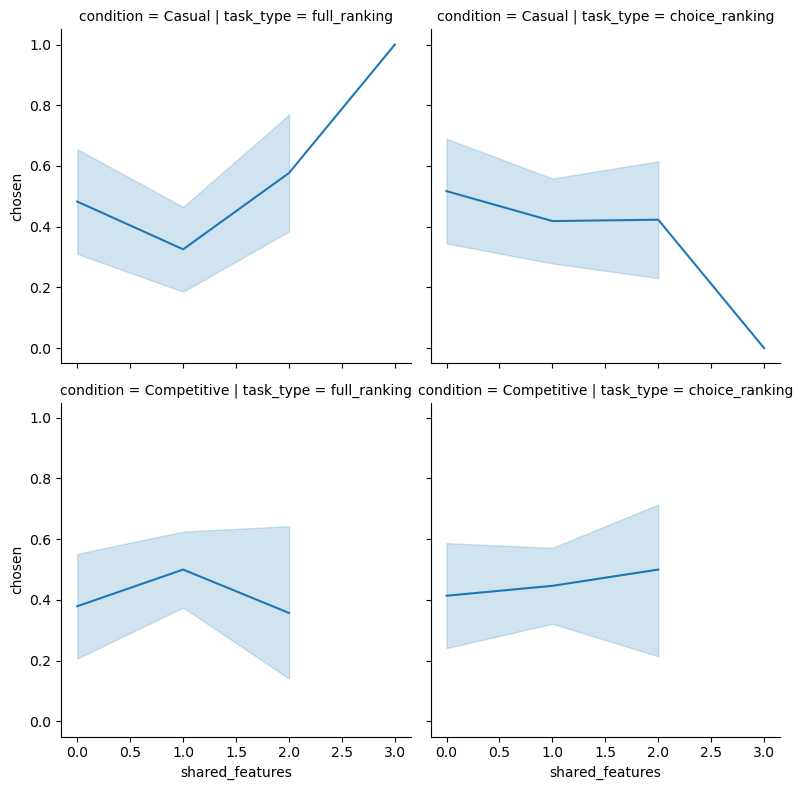

In [16]:
g = sns.FacetGrid(data, col='task_type', row='condition', sharey=True, height=4)
g.map(sns.lineplot, 'shared_features', 'chosen')

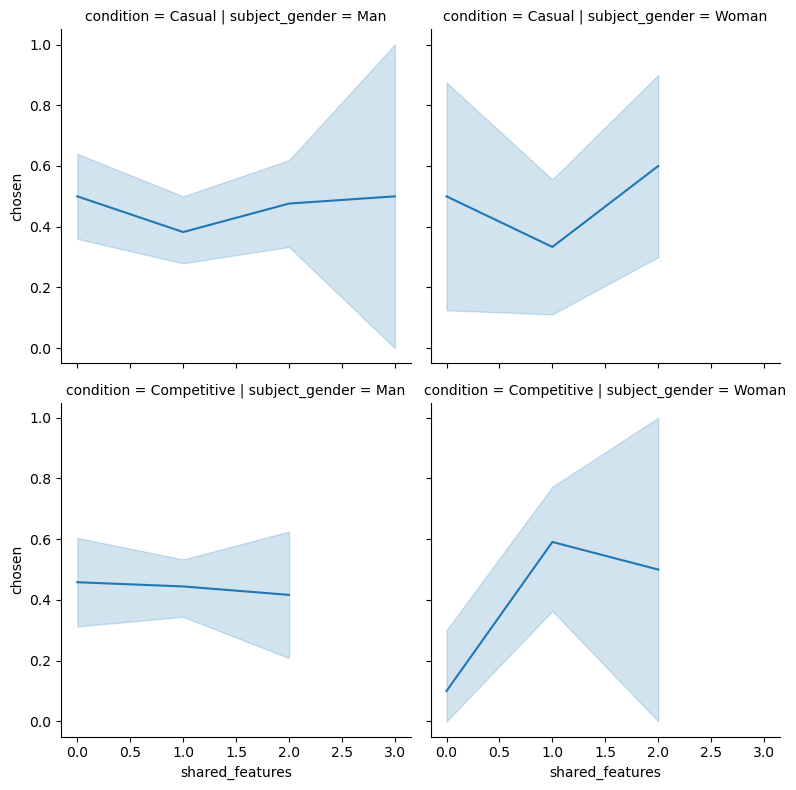

In [17]:
g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True, height=4)
g.map(sns.lineplot, 'shared_features', 'chosen')

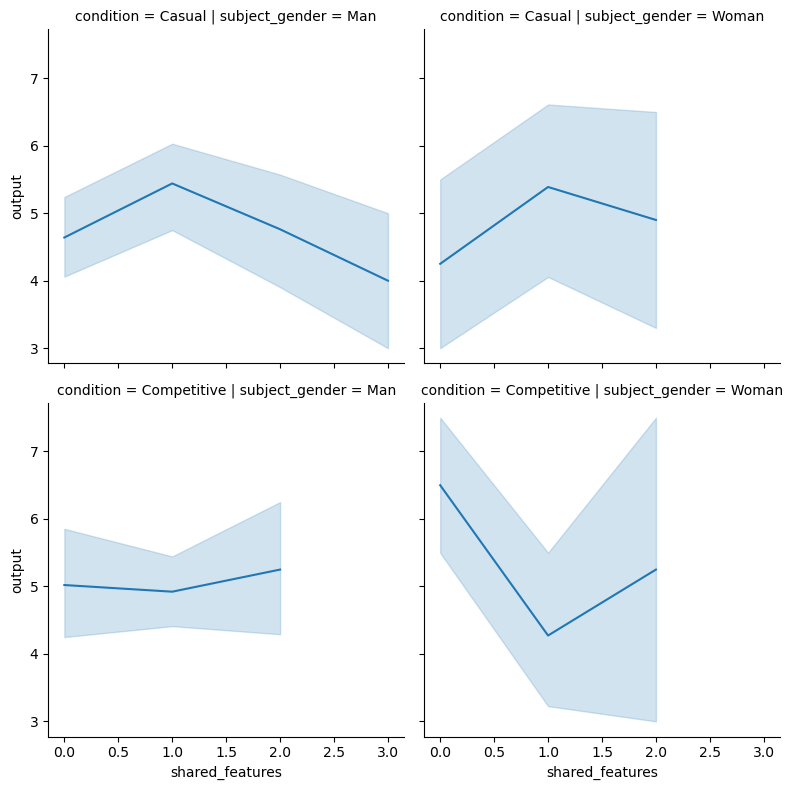

In [18]:
g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True, height=4)
g.map(sns.lineplot, 'shared_features', 'output')

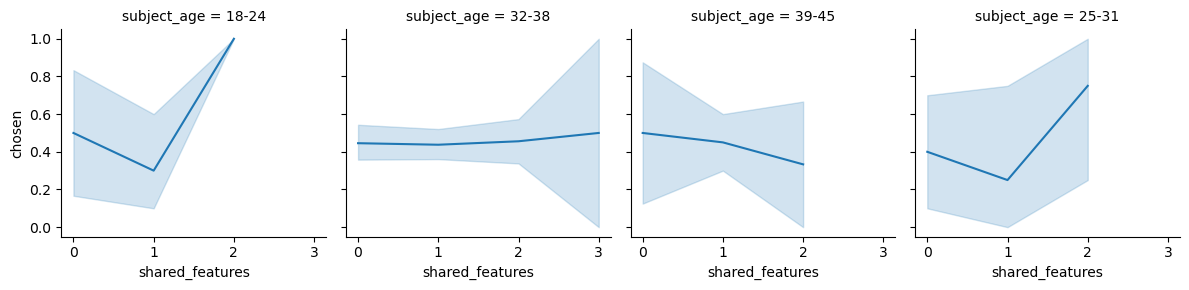

In [19]:
g = sns.FacetGrid(data, col='subject_age', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

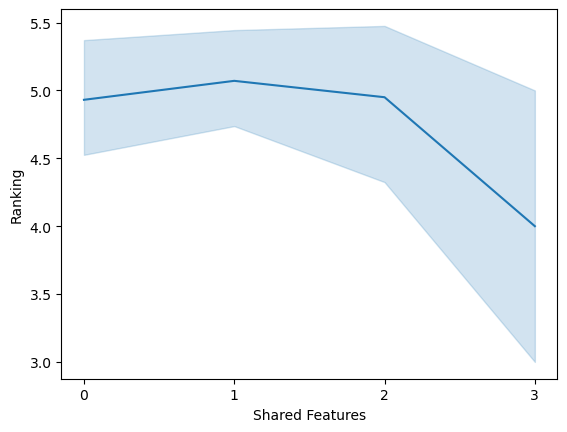

In [20]:
g = sns.lineplot(
    data=data, 
    y='output', x='shared_features')
g.set_ylabel('Ranking')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3]);

In [21]:
data.to_csv('experiments/sortablerank/third_pass_data.csv', index=False)

<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_2667/3531074520.py:72: SyntaxWarning: invalid escape sequence '\d'
  data_long['shared_feature_level'] = data_long['shared_feature_level'].str.extract('(\d+)').astype(int)
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_2667/3531074520.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_2667/3531074520.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a

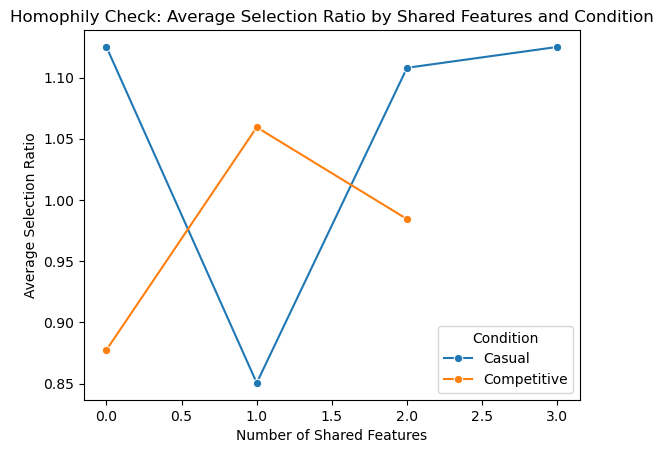

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_homophily_check(data):
    """
    This function takes a pandas DataFrame and performs the homophily check analysis,
    plotting the average selection ratio against the number of shared features for each condition.
    """
    # Step 1: Calculate counts of each shared feature level for each subject and retain condition
    feature_counts = data.groupby('subject').apply(
        lambda x: pd.Series({
            'condition': x['condition'].iloc[0],
            'count_0': (x['shared_features'] == 0).sum(),
            'count_1': (x['shared_features'] == 1).sum(),
            'count_2': (x['shared_features'] == 2).sum(),
            'count_3': (x['shared_features'] == 3).sum(),
        })
    ).reset_index()

    # Step 2: Join these counts back to the main data frame based on the subject
    data = data.drop(columns=['condition'])
    data = data.merge(feature_counts, on='subject', how='left')

    # Step 3: Calculate expected proportions for each subject and shared feature level
    expected_proportions = data.groupby('subject').apply(
        lambda x: pd.Series({
            'condition': x['condition'].iloc[0],
            'expected_prop_0': (x['shared_features'] == 0).sum() / 9,
            'expected_prop_1': (x['shared_features'] == 1).sum() / 9,
            'expected_prop_2': (x['shared_features'] == 2).sum() / 9,
            'expected_prop_3': (x['shared_features'] == 3).sum() / 9,
        })
    ).reset_index()

    # Step 4: Calculate observed proportions for each subject and shared feature level
    observed_counts = data[data['chosen'] == 1].groupby(['subject', 'shared_features']).size().unstack(fill_value=0).reset_index()
    observed_counts.columns.name = None

    # Rename the columns to ensure they match expected names
    for i in range(4):
        col_name = f'observed_{i}'
        if i in observed_counts.columns:
            observed_counts.rename(columns={i: col_name}, inplace=True)
        else:
            observed_counts[col_name] = 0

        observed_counts[f'observed_prop_{i}'] = observed_counts[col_name] / 4

    # Keep only subject and observed_prop columns
    observed_proportions = observed_counts[['subject'] + [f'observed_prop_{i}' for i in range(4)]]

    # Step 5: Join expected and observed proportions, retaining condition without duplicates
    data_proportions = expected_proportions.merge(observed_proportions, on='subject', how='left')

    # Step 6: Calculate proportional ratios for each shared feature level
    for i in range(4):
        data_proportions[f'ratio_{i}'] = data_proportions[f'observed_prop_{i}'] / data_proportions[f'expected_prop_{i}']

    # Step 7: Reshape data to long format for easier plotting and comparison
    id_vars = ['subject', 'condition']
    value_vars = [f'ratio_{i}' for i in range(4)]
    data_long = pd.melt(
        data_proportions,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='shared_feature_level',
        value_name='selection_ratio'
    )

    # Extract shared_feature_level as numeric
    data_long['shared_feature_level'] = data_long['shared_feature_level'].str.extract('(\d+)').astype(int)

    # Step 8: Calculate average selection ratio by shared feature level and condition
    average_ratios = data_long.groupby(['condition', 'shared_feature_level'])['selection_ratio'].mean().reset_index(name='mean_ratio')

    # Step 9: Plot average selection ratio against number of shared features for each condition
    sns.lineplot(
        data=average_ratios,
        x='shared_feature_level',
        y='mean_ratio',
        hue='condition',
        marker='o'
    )
    plt.xlabel('Number of Shared Features')
    plt.ylabel('Average Selection Ratio')
    plt.title('Homophily Check: Average Selection Ratio by Shared Features and Condition')
    plt.legend(title='Condition')
    plt.show()
    # Optionally, save the plot
    # plt.savefig('homophily_check.png')

plot_homophily_check(data)